# Hooks 9
---


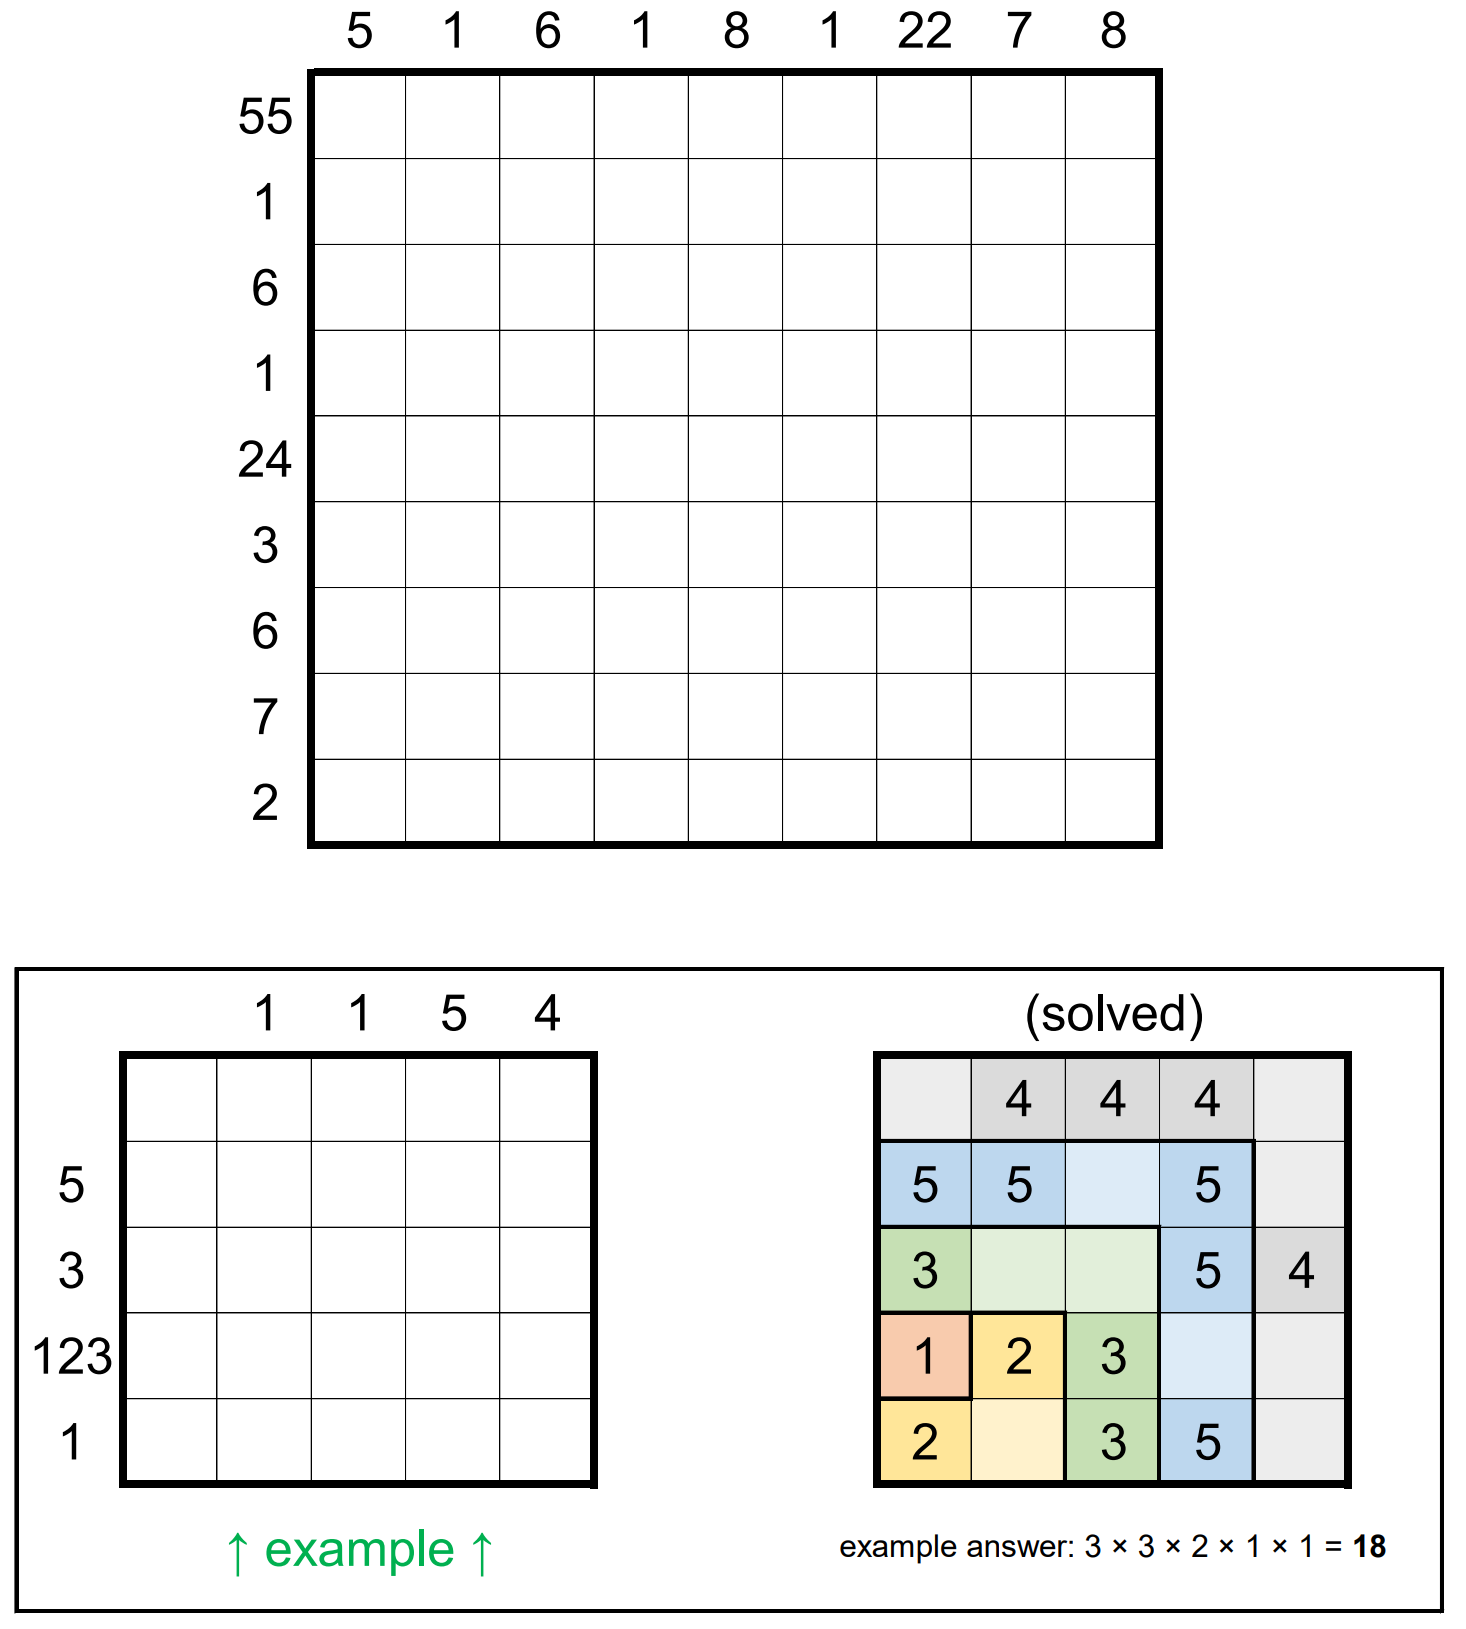

The grid above can be partitioned into 9 L-shaped “hooks”. The largest is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains 15 squares), and so on. The smallest hook is just a single square. Find where the hooks are located, and place nine 9’s in one of the hooks, eight 8’s in another, seven 7’s in another, and so on.

The filled squares must form a connected region. (Squares are “connected” if they are orthogonally adjacent.) Furthermore, every 2-by-2 region must contain at least one unfilled square.

The numbers outside the grid denote the greatest common divisors (GCDs) of the numbers formed by concatenating digits in consecutive squares when reading left-to-right (within rows) or top-to-bottom (within columns).

The answer to this puzzle is the product of the areas of the connected groups of empty squares in the completed grid.



Solving the puzzle:

**Initial Observations:**

For the GCD of the top row and left column to be 55 and 5 respectively, it is necessary that they only contain numbers that end in 5. Furthermore, we can deduce the top row only contains '55', and since there are five 5s, there must exist a 5 on the leftmost column that isn't the top-left vertex.

From this, we conclude that the there is a hook running bending around the top-left vertex, which contains the 5s. Because the hook containing 5s bends across the top-left vertex, the largest (17x17) hook must either be this hook, or be the hook bending across the bottom-right vertex. (Since it cannot "cut" the top left vertex). By looking at the GCD of the bottom row and rightmost column (2 and 8), we can eliminate the possibility it bends across the bottom-right vertex, hence we get that the largest hook bends across the topleft vertex and contains the 5s.

**Narrowing the search with code**

Efforts to solve the puzzle solely by hand prove too difficult, so a program was written to narrow the search. The strategy was as follows:

1. Place hooks and place numbers (4^7 different combinations of hooks, and at most 240 ways to place nums since some can be instantly eliminated, e.g. you cant place 9s in the 3x3 hook)
2. Generate a set of possible combinations based on the gcd of rows/columns, and filter it down, (e.g. if I have 24, and the nums along that row are (0/5, 0/9, 0/6, 0/4, 0/3, 1, 0/2, 0/7, 0/8), one of the possible combinations generated will be (0,9,6,0,3,1,2,0,0)
3. Eliminate possible values based on the set of possible combinations of gcd (e.g. if (0,0,0,0,...) and (7,0,7,0,...) are the only possible combinations along a row, then I can write it as (0/7, 0, 0/7, 0)
4. Repeat step 3, and also apply the other "filters" (such as counting how many of each number there are) to gradually eliminate numbers, or based on 2x2 squares needing to have a 0 or connectivity

By (partially) applying the rules, the search was narrowed down to 2 boards, which were then solved by hand.

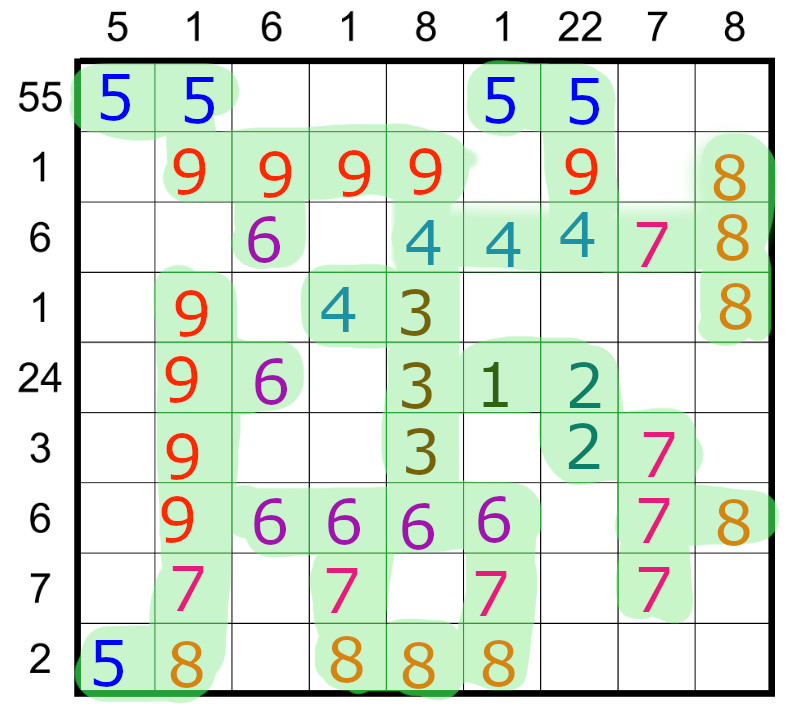

This gives a final answer of 15,552

In [ ]:
import math
ans_set = None
# sets up the possible values on the board given the hooks.
# format of hooks: (Numbered LARGEST HOOK FIRST e.g. 17x17 hook contains 5)
# hooks = [
#  [5,9,8,7,6,4,3,2,1],
#  [1,1,3,3,1,4,4,2,1]
# ]
# TOP ROW: Numbers in the hooks.
# BOTTOM ROW: The rotation of each hook. 0 = UNPLACED | 1 = TOP-LEFT | 2 = TOP-RIGHT | 3 = BOTTOM-RIGHT | 4 = BOTTOM-LEFT
def poss_vals(hooks):
  pos_board = [
      [{0} for i in range(9)] for j in range(9)
  ]
  hookt = 0
  hookb = 8
  hookl = 0
  hookr = 8
  for i in range(9):
    if hooks[1][i] == 1:
      for j in range(hookt,hookb+1):
        pos_board[j][hookl].add(hooks[0][i])
      for j in range(hookl+1,hookr+1):
        pos_board[hookt][j].add(hooks[0][i])
      hookl += 1
      hookt += 1
    elif hooks[1][i] == 2:
      for j in range(hookt,hookb+1):
        pos_board[j][hookr].add(hooks[0][i])
      for j in range(hookl,hookr):
        pos_board[hookt][j].add(hooks[0][i])
      hookr -= 1
      hookt += 1
    elif hooks[1][i] == 3:
      for j in range(hookt,hookb+1):
        pos_board[j][hookr].add(hooks[0][i])
      for j in range(hookl,hookr):
        pos_board[hookb][j].add(hooks[0][i])
      hookr -= 1
      hookb -= 1
    elif hooks[1][i] == 4:
      for j in range(hookt,hookb+1):
        pos_board[j][hookl].add(hooks[0][i])
      for j in range(hookl+1,hookr+1):
        pos_board[hookb][j].add(hooks[0][i])
      hookl += 1
      hookb -= 1
  return pos_board

def pretty_print(posboard):
  for i in range(9):
    for j in range(9):
      if len(posboard[i][j]) == 1: print("| "+str(posboard[i][j])+"  |",end='')
      else: print("|"+str(posboard[i][j])+"|",end='')
    print()

# some initial pre-processing of the board to reduce the number of possible values
def process_pos_board(pos_board):
  pos_board[0][8] = {0}
  pos_board[0][7] = {0}
  for i in range(9):
    for j in range(9):
      if 1 in pos_board[i][j]: pos_board[i][j] = {1}
      if (i == 8 and j in {2,4,6,8}) or (j == 8 and i in {2,4,6,8}):
        pos_board[i][j] = pos_board[i][j].intersection({0,2,4,6,8})
  return pos_board

# takes in an int gcd and a list of possible vals (in the form of sets).
# modifies "ans_set" to become the set of possible ways to fill the row/column to match the gcd
def findMultiples(gcd, poss, ans_set = set(), curr_val = 0, excluded_vals = {5},prev_vals=(),failed=False):
  if len(poss) == 0:
    if curr_val%gcd == 0:
      # check gcd
      # 24 is banned
      prev_num = 0
      curr_num = 0
      v = -1
      for j in range(len(prev_vals)):
        if prev_vals[j] == 0:
          if prev_num == 0: prev_num = curr_num
          if curr_num != 0 and prev_num != 0: v = math.gcd(prev_num, curr_num)
          curr_num = 0
        else:
          curr_num *= 10
          curr_num += prev_vals[j]
      if prev_num == 0: prev_num = curr_num
      if curr_num != 0: v = math.gcd(prev_num, curr_num)
      if v == gcd: ans_set.add(prev_vals)
  elif poss[0] == {}:
    for j in range(10):
      if j not in excluded_vals:
        if len(prev_vals) > 1 and prev_vals[-1] != prev_vals[-2]:
          excluded_vals = excluded_vals.copy()
          if (prev_vals[-2] != 0): excluded_vals.add(prev_vals[-2])
          if prev_vals[-1] == 1: excluded_vals.add(1) # dont let 1 repeat
        if j == 0:
          # what if we banned 22 and 24?  and curr_val != 22 and curr_val != 24
          if curr_val%gcd == 0: findMultiples(gcd, poss[1:], ans_set=ans_set, curr_val = 0, excluded_vals = excluded_vals,prev_vals = prev_vals+(j,))
        else: findMultiples(gcd, poss[1:], ans_set=ans_set, curr_val = curr_val*10+j, excluded_vals = excluded_vals,prev_vals = prev_vals+(j,))
  else:
    for j in poss[0]:
        if j == 0:
          if curr_val%gcd == 0: findMultiples(gcd, poss[1:], ans_set=ans_set, curr_val = 0, excluded_vals = excluded_vals,prev_vals = prev_vals+(j,))
        else: findMultiples(gcd, poss[1:], ans_set=ans_set, curr_val = curr_val*10+j, excluded_vals = excluded_vals,prev_vals = prev_vals+(j,))
  return ans_set

# takes in an axis (0 = rows, 1 = columns) and finds combos for row/column n. Updates posboard to the new possible values.
# returns 'None' object if no possibilities.
def gcd_reduce(posboard,n,axis=0):
  row_divs = [55,1,6,1,24,3,6,7,2]
  col_divs = [5,1,6,1,8,1,22,7,8]
  ans_set = set()
  if axis == 0:
    findMultiples(row_divs[n],posboard[n],ans_set = ans_set)
    if len(ans_set) == 0: return None
    posboard[n] = [set(),set(),set(),set(),set(),set(),set(),set(),set()]
    for ans in ans_set:
      for i in range(9): posboard[n][i].add(ans[i])
  else:
    li = []
    for i in range(9): li.append(posboard[i][n])
    findMultiples(col_divs[n],li,ans_set = ans_set)
    if len(ans_set) == 0: return None
    for i in range(9): posboard[i][n] = set()
    for ans in ans_set:
      for i in range(9): posboard[i][n].add(ans[i])
  return posboard

# TODO
def count_and_clear(posboard):
  counts = [0,0,0,0,0,0,0,0,0,0]
  poss_counts = [0,0,0,0,0,0,0,0,0,0]
  for i in range(9):
    for j in range(9):
      #if len(posboard[i][j] == 1) and 0 not in posboard[i][j]:
      poss_counts[max(posboard[i][j])] += 1
      counts[min(posboard[i][j])] += 1
  for k in range(2,10):
    if counts[k] > k: return None
    elif (counts[k] == k):
      for i in range(9):
        for j in range(9):
          if k in posboard[i][j] and 0 in posboard[i][j]: posboard[i][j] = {0}
    elif poss_counts[k] < k: return None
    elif (poss_counts[k] == k):
      for i in range(9):
        for j in range(9):
          if k in posboard[i][j]: posboard[i][j] = {k}
  return posboard

def connectivity_simple(posboard):
  # do this by corner
  # bottom right
  if len(posboard[7][8]) == 1 and 0 in posboard[7][8] and len(posboard[8][7]) == 1 and 0 in posboard[8][7]:
    if 0 in posboard[8][8]: posboard[8][8] = {0}
    else: return None
  # bottom left
  if len(posboard[7][1]) == 1 and 0 in posboard[7][1]:
    if (len(posboard[8][2]) == 1 and 0 in posboard[8][2]) or (len(posboard[8][1]) == 1 and 0 in posboard[8][1]):
      if (len(posboard[7][0]) == 1 and 0 in posboard[7][0]) or (len(posboard[6][0]) == 1 and 0 in posboard[6][0]):
        if 0 in posboard[8][0] and 0 in posboard[7][0] and 0 in posboard[8][1]:
          posboard[8][0] = {0}
          posboard[7][0] = {0}
          posboard[8][1] = {0}
        else: return None
  return posboard
def find_valid_posboards(posboard, hookinfo = None):
  # using gcd 24 (row 4) and gcd 22 (col 6)
  posboard = gcd_reduce(posboard,4,axis=0)
  if posboard: posboard = gcd_reduce(posboard,6,axis=1)
  if posboard: posboard = gcd_reduce(posboard,2,axis=0)
  if posboard: posboard = gcd_reduce(posboard,6,axis=0)
  if posboard: posboard = gcd_reduce(posboard,7,axis=0)
  if posboard: posboard = gcd_reduce(posboard,8,axis=0)
  if posboard: posboard = gcd_reduce(posboard,2,axis=1)
  if posboard: posboard = gcd_reduce(posboard,4,axis=1)
  if posboard: posboard = gcd_reduce(posboard,7,axis=1)
  if posboard: posboard = gcd_reduce(posboard,8,axis=1)
  if posboard: posboard = gcd_reduce(posboard,4,axis=0)
  if posboard: posboard = gcd_reduce(posboard,6,axis=1)
  if posboard: posboard = count_and_clear(posboard)
  if posboard: posboard = gcd_reduce(posboard,4,axis=0)
  if posboard: posboard = gcd_reduce(posboard,6,axis=1)
  if posboard: posboard = gcd_reduce(posboard,2,axis=0)
  if posboard: posboard = gcd_reduce(posboard,6,axis=0)
  if posboard: posboard = gcd_reduce(posboard,7,axis=0)
  if posboard: posboard = gcd_reduce(posboard,8,axis=0)
  if posboard: posboard = gcd_reduce(posboard,2,axis=1)
  if posboard: posboard = gcd_reduce(posboard,4,axis=1)
  if posboard: posboard = gcd_reduce(posboard,7,axis=1)
  if posboard: posboard = gcd_reduce(posboard,8,axis=1)
  if posboard: posboard = gcd_reduce(posboard,4,axis=0)
  if posboard: posboard = gcd_reduce(posboard,6,axis=1)
  if posboard: posboard = connectivity_simple(posboard)
  if posboard: posboard = count_and_clear(posboard)
  if posboard: posboard = gcd_reduce(posboard,4,axis=0)
  if posboard: posboard = gcd_reduce(posboard,6,axis=1)
  if posboard: posboard = gcd_reduce(posboard,2,axis=0)
  if posboard: posboard = gcd_reduce(posboard,6,axis=0)
  if posboard: posboard = gcd_reduce(posboard,7,axis=0)
  if posboard: posboard = gcd_reduce(posboard,8,axis=0)
  if posboard: posboard = gcd_reduce(posboard,2,axis=1)
  if posboard: posboard = gcd_reduce(posboard,4,axis=1)
  if posboard: posboard = gcd_reduce(posboard,7,axis=1)
  if posboard: posboard = gcd_reduce(posboard,8,axis=1)
  if posboard: posboard = gcd_reduce(posboard,4,axis=0)
  if posboard: posboard = gcd_reduce(posboard,6,axis=1)
  if posboard: posboard = connectivity_simple(posboard)
  if posboard:
    print("________")
    pretty_print(posboard)
  """ans_set1 = set()
  findMultiples(24,pos_board[4],ans_set = ans_set1)
  for sol in ans_set1:
    li = []
    for i in range(9):
      if i == 4: li.append({sol[6]})
      else: li.append(pos_board[i][6])
    ans_set2 = set()
    findMultiples(22,li,ans_set=ans_set2)
    for sol2 in ans_set2:
      print(" | row 24 | "+str(sol), end='')
      print(" | col 22 | "+str(sol2))
      if hookinfo != None: print(" Hook Info: "+str(hookinfo))"""
      # p = [pos_board[i].copy() for i in range(9)]
      # for i in range(9):
      #  p[4][i] = {sol[i]}
      #  p[i][6] = {sol2[i]}
      #
      #for i in range(9): print(p[i])
  #print(ans_set2)

# pos_board = poss_vals(hooks)
# process_pos_board(pos_board)
# find_valid_posboards(pos_board, hooks)

# hook = [[5, 9, 8, 7, 6, 4, 3, 2, 1], [1, 1, 3, 3, 1, 4, 4, 2, 1]]

# generate hooks to try
# ~4 million combinations to check.
progress = 0
percent_complete = 0
for i in range(16384):
  progress += 1
  if progress >= 820:
    progress = 0
    percent_complete += 5
    print(str(percent_complete)+"% complete")
  li = [1]
  temp = i
  for j in range(7):
    li.append(temp%4+1)
    temp = temp//4
  li.append(1)
  for j in range(240):
    li2=[5]
    temp = j//2
    if j%2 == 0: lastdigit = 3
    else: lastdigit = 4
    s = [9,8,7,6,7-lastdigit]
    for k in range(5,0,-1):
      li2.append(s.pop(temp%k))
      temp //= k
    if li2[5] == 9 or li2[5] == 8: continue
    li2.extend([lastdigit,2,1])
    hooks = [li2,li]
    pos_board = poss_vals(hooks)
    process_pos_board(pos_board)
    find_valid_posboards(pos_board, hooks)
#for i in range(9): print(pos_board[i])
#return_valid_posboards

5% complete
10% complete
15% complete
20% complete
25% complete
30% complete
35% complete
40% complete
________
|{0, 5}||{0, 5}|| {0}  ||{0, 5}||{0, 5}||{0, 5}|| {0}  || {0}  || {0}  |
|{0, 5}||{0, 9}||{0, 9}||{0, 9}||{0, 9}||{0, 9}|| {0}  ||{0, 7}||{8, 0}|
|{0, 5}||{0, 9}||{0, 6}||{0, 4}||{0, 4}||{0, 4}|| {0}  ||{0, 7}||{0, 8}|
|{0, 5}||{0, 9}||{0, 6}||{0, 4}||{0, 3}|| {0}  || {2}  ||{0, 7}||{8, 0}|
| {0}  || {9}  || {6}  || {0}  || {3}  || {1}  || {2}  || {0}  || {0}  |
|{0, 5}||{0, 9}||{0, 6}||{0, 4}|| {3}  ||{0, 3}|| {0}  ||{0, 7}||{0, 8}|
| {0}  ||{0, 9}||{0, 6}||{0, 6}|| {6}  ||{0, 6}|| {0}  ||{0, 7}||{0, 8}|
| {0}  ||{0, 7}|| {0}  ||{0, 7}|| {0}  ||{0, 7}|| {0}  ||{0, 7}|| {0}  |
| {5}  || {8}  || {0}  ||{0, 8}|| {8}  ||{8, 0}|| {0}  || {0}  || {0}  |
45% complete
50% complete
________
|{0, 5}||{0, 5}|| {0}  ||{0, 5}||{0, 5}||{0, 5}||{0, 5}|| {0}  || {0}  |
|{0, 5}||{0, 9}||{0, 9}||{0, 9}||{0, 9}||{0, 9}||{0, 9}||{0, 7}||{8, 0}|
|{0, 5}||{0, 9}||{0, 6}||{0, 4}||{0, 4}||{0, 4}||{

In [ ]:
hook = [[5, 9, 8, 7, 6, 4, 3, 2, 1], [1, 1, 3, 3, 1, 4, 4, 2, 1]]
pb = poss_vals(hook)
pb = gcd_reduce(pb,6,axis=1)
pb = count_and_clear(pb)
pretty_print(pb)

|{0, 5}||{0, 5}||{0, 5}||{0, 5}||{0, 5}||{0, 5}|| {0}  ||{0, 5}||{0, 5}|
|{0, 5}||{0, 9}||{0, 9}||{0, 9}||{0, 9}||{0, 9}|| {0}  ||{0, 9}||{0, 9}|
|{0, 5}||{0, 9}||{0, 6}||{0, 6}||{0, 6}||{0, 6}|| {0}  ||{0, 7}||{0, 8}|
|{0, 5}||{0, 9}||{0, 6}||{0, 4}||{0, 3}|| {0}  || {2}  ||{0, 7}||{0, 8}|
|{0, 5}||{0, 9}||{0, 6}||{0, 4}||{0, 3}||{0, 1}|| {2}  ||{0, 7}||{0, 8}|
|{0, 5}||{0, 9}||{0, 6}||{0, 4}||{0, 3}||{0, 3}|| {0}  ||{0, 7}||{0, 8}|
|{0, 5}||{0, 9}||{0, 6}||{0, 4}||{0, 4}||{0, 4}|| {0}  ||{0, 7}||{0, 8}|
|{0, 5}||{0, 9}||{0, 7}||{0, 7}||{0, 7}||{0, 7}|| {0}  ||{0, 7}||{0, 8}|
|{0, 5}||{0, 9}||{0, 8}||{0, 8}||{0, 8}||{0, 8}|| {0}  ||{0, 8}||{0, 8}|
